<a href="https://colab.research.google.com/github/Samin-Sadaf7/QuestionAnswerGenerator/blob/main/RealTimeMultimodalRag_with_GeminiProVision_Langchain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
!pip install --upgrade --quiet langchain langchain_core langchain-google-genai "langchain[docarray]" faiss-cpu pypdf

In [145]:
import os
import requests
from PIL import Image

In [146]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import display, Markdown

In [147]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage
from langchain_community.vectorstores import DocArrayInMemorySearch
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

In [148]:
from langchain.schema.document import Document
from langchain_community.document_loaders import TextLoader

In [149]:
from langchain_text_splitters import CharacterTextSplitter

In [150]:
from langchain_community.vectorstores import FAISS

In [151]:
from google.colab import userdata
GOOGLE_API_KEY = userdata.get('GeminiKey')
os.environ['GOOGLE_API_KEY'] = GOOGLE_API_KEY

In [152]:
def load_model(model_name):
  llm = ChatGoogleGenerativeAI(model=model_name)
  return llm

In [153]:
llm = load_model("gemini-pro")

In [154]:
llm.invoke("Please tell me something to reply to my thesis supervisor who asked me to sit with him regularly but I have internship and I need to tell him I along with my teammates are trying to manage time").content

"Dear Professor [Supervisor's Name],\n\nThank you for reaching out and suggesting regular meetings. I appreciate your support and guidance.\n\nI would like to express my commitment to the progress of my thesis. However, I am currently engaged in a demanding internship that requires significant time and attention.\n\nMy teammates and I are actively working to manage our schedules effectively in order to balance our internship responsibilities with our academic commitments. Unfortunately, it may not be feasible for me to meet with you as frequently as you have suggested at this time.\n\nI am open to exploring alternative arrangements that could accommodate my current situation. For example, I would be happy to schedule shorter and more frequent meetings, or to meet virtually. I am also willing to adjust my internship schedule if necessary.\n\nI would appreciate the opportunity to discuss this further with you and find a solution that works for both of us. Please let me know when you woul

In [155]:
def get_image(url, filename, extension):
  content = requests.get(url).content
  with open(f'/content/{filename}.{extension}', 'wb') as handler:
    handler.write(content)
  image = Image.open(f"/content/{filename}.{extension}")
  image.show()
  return image

In [156]:
image = get_image("https://images.unsplash.com/photo-1530026405186-ed1f139313f8?w=400&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxzZWFyY2h8MTB8fGhlYXJ0fGVufDB8fDB8fHww",
                  "heart",
                  "png"
                  )

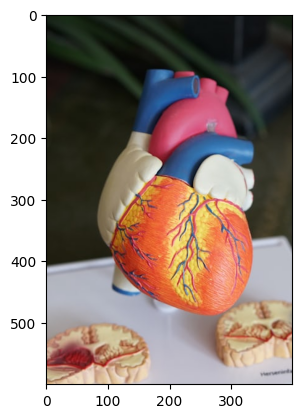

In [157]:
plt.imshow(image)
plt.show()

In [158]:
vision_model = load_model('gemini-pro-vision')

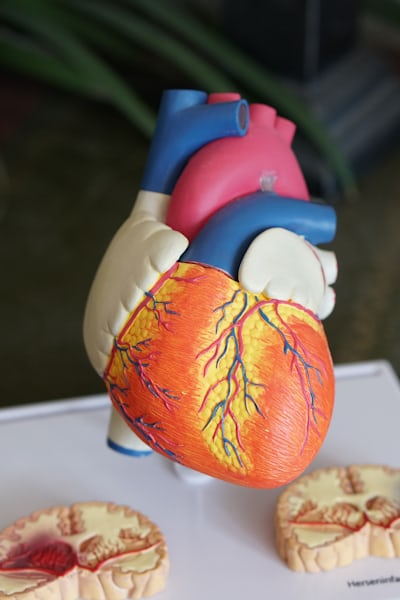

In [159]:
image

In [160]:
prompt = "Combine image information with context and try to find relevant things and explain deeply"

In [161]:
message = HumanMessage(
    content = [
        {
          "type":"text",
          "text" : prompt
        },
        {
            "type":"image_url",
            "image_url": '/content/heart.png'
        }
    ]
)

In [162]:
message

HumanMessage(content=[{'type': 'text', 'text': 'Combine image information with context and try to find relevant things and explain deeply'}, {'type': 'image_url', 'image_url': '/content/heart.png'}])

In [163]:
vision_model.invoke([message]).content

' The image shows a model of a human heart. The heart is a muscular organ that pumps blood throughout the body. It is located in the center of the chest, behind the sternum. The heart is divided into four chambers: two atria and two ventricles. The atria receive blood from the body and the ventricles pump blood out to the body. The heart is surrounded by a sac called the pericardium. The pericardium protects the heart and helps to keep it in place.'

In [164]:
loader = TextLoader("/content/c_plus_plus.txt")
text = loader.load()[0].page_content

In [165]:
def get_text_chunks_langchain(text):
  textsplitter = CharacterTextSplitter(chunk_size=10, chunk_overlap=2)
  docs = [Document(page_content=t) for t in textsplitter.split_text(text)]
  return docs

In [ ]:
docs = get_text_chunks_langchain(text)

In [167]:
embeddings=  GoogleGenerativeAIEmbeddings(model = "models/embedding-001")

In [168]:
vectorstore = FAISS.from_documents(docs, embeddings)

In [169]:
retriever = vectorstore.as_retriever()

In [170]:
retriever.invoke("C++")

[Document(page_content="**Advanced Topics** |\nC++ isn't just about the basics; it offers advanced features that enhance its power."),
 Document(page_content="| **C++ Programming** |\n|----------------------|\n| **Introduction** |\nC++ programming is like the Swiss Army knife of coding languages. It's versatile, powerful, and has been around for decades, evolving with the times to remain relevant and indispensable. Whether you're delving into game development, system software, or even just learning programming for the first time, C++ has something to offer. Let's embark on this journey to uncover the intricacies and charm of C++ programming."),
 Document(page_content='**Basics of C++ Programming** |\nGetting started with C++ requires understanding its fundamental building blocks.'),
 Document(page_content='**Evolution** |\nSince its inception, C++ has undergone numerous changes and improvements. The ANSI standardization in 1998 (ISO/IEC 14882:1998) was a significant milestone, followed

In [171]:
from langchain_core.runnables import RunnableLambda, RunnablePassthrough

In [172]:
llm_vision = load_model("gemini-pro-vision")

In [173]:
llm_text = load_model("gemini-pro")

In [174]:
template = """
` {{context}}`
{information}
"""

In [175]:
prompt = ChatPromptTemplate.from_template(template)

In [176]:
rag_chain = (
    {"context": retriever, "information": RunnablePassthrough()} |
    prompt |
    llm_text |
    StrOutputParser()
)

In [177]:
result = rag_chain.invoke("heart")

In [178]:
display(result)

'love'

In [179]:
full_chain = (
    RunnablePassthrough() |
    llm_vision |
    StrOutputParser() |
    rag_chain
)

In [180]:
full_chain

RunnablePassthrough()
| ChatGoogleGenerativeAI(model='models/gemini-pro-vision', client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7e3882339210>, async_client=<google.ai.generativelanguage_v1beta.services.generative_service.async_client.GenerativeServiceAsyncClient object at 0x7e3882339e40>, default_metadata=())
| StrOutputParser()
| {
    context: VectorStoreRetriever(tags=['FAISS', 'GoogleGenerativeAIEmbeddings'], vectorstore=<langchain_community.vectorstores.faiss.FAISS object at 0x7e388279c6d0>),
    information: RunnablePassthrough()
  }
| ChatPromptTemplate(input_variables=['information'], messages=[HumanMessagePromptTemplate(prompt=PromptTemplate(input_variables=['information'], template='\n` {{context}}`\n{information}\n'))])
| ChatGoogleGenerativeAI(model='models/gemini-pro', client=<google.ai.generativelanguage_v1beta.services.generative_service.client.GenerativeServiceClient object at 0x7e388233ab60>, async_cli

In [181]:
result = full_chain.invoke([message])

In [182]:
display(Markdown(result))

**The Heart**

The heart is a vital organ that pumps blood throughout the body. It is located in the center of the chest and is about the size of a fist. The heart is made up of four chambers: two atriums and two ventricles. The atriums receive blood from the body, and the ventricles pump blood out to the body. The heart is surrounded by a sac called the pericardium. The pericardium protects the heart and helps to keep it in place.

The heart is a very complex organ, and it is essential for life. It is important to take care of your heart by eating a healthy diet, exercising regularly, and avoiding smoking.

**Functions of the Heart**

The heart has several important functions, including:

* Pumping blood throughout the body
* Delivering oxygen and nutrients to the body's tissues
* Removing waste products from the body
* Regulating blood pressure
* Maintaining body temperature

**Heart Disease**

Heart disease is the leading cause of death in the United States. There are many different types of heart disease, but the most common are:

* Coronary artery disease (CAD)
* Heart attack
* Heart failure
* Stroke

Heart disease can be prevented by making healthy lifestyle choices, such as:

* Eating a healthy diet
* Exercising regularly
* Avoiding smoking
* Managing blood pressure
* Controlling cholesterol levels

If you have any symptoms of heart disease, it is important to see your doctor right away. Heart disease can be treated, but it is important to get treatment as early as possible.